In [1]:
import os
import xml.etree.ElementTree as ex

os.environ["CUDA_VISIBLE_DEVICES"]="2"

sample_labels = ["LMCI", "EMCI"]
label_to_id = {}      # key: class name
                    # value: class id
file_to_apoe = {}   # key: image file path
                    # value: boolean, true if image specified 4 in either "APOE A1" or "APOE A2" fields

# This is for getting ADNI files
def get_filenames(folder, metadata_folder):
    global label_to_id
    for i, label in enumerate(sample_labels):
        label_to_id[label] = i
         
    # Get list of images
    image_class = {} # key: unique subject id in filename
                     # value: image file path
    for root, directories, filenames in os.walk(folder):
        for filename in filenames:
            if filename.endswith("nii") and "__Scaled_2" not in root:
                identifier = filename[-11:-4]
                image_class[identifier] = os.path.join(root,filename)
                
    meta_files = [f for f in os.listdir(metadata_folder) if f.endswith('xml')]
        
    # Label each image
    classify_by_label = {} # key: label class in [0, 1, 2, 3]
                           # value: list of image file paths
    for xml in meta_files:
        if "__Scaled_2" not in xml:
            identifier = xml[-11:-4]
            root = ex.parse(metadata_folder + "/" + xml).getroot()
            classification = root[0][3][1].text
            if classification in label_to_id:
                cl = label_to_id[classification]
                file_path = image_class[identifier]
                if cl not in classify_by_label:
                    classify_by_label[cl] = [file_path]
                else:
                    classify_by_label[cl].append(file_path)
                
                # Storing APOE e4 carrier information for each image file
                apoe_1 = root[0][3][4].text
                apoe_2 = root[0][3][5].text
                
                file_to_apoe[file_path] = False
                if apoe_1 == "4" or apoe_2 == "4":
                    file_to_apoe[file_path] = True
                    
    print("Statistics: {}".format(get_stats(classify_by_label)))
    
    return classify_by_label

def get_stats(files):
    stats = {}
    for k, v in files.items():
        stats[sample_labels[int(k)]] = len(v)
    return stats


In [2]:
import matplotlib.pyplot as plt
from nilearn import image
import nibabel as nib
import numpy as np
import tensorflow as tf
from scipy import ndimage as nd

def get_files(data_folder, metadata_folder):
    files = get_filenames(data_folder, metadata_folder)
    return files 

# Size of desired image
width = 80
height = 80
depth = 80

def get_data(files, class_id):
    global width, height, depth
    num_images = len(files)
    
    x_data = np.zeros([num_images, height, width, depth], np.float32)
    y_data = np.zeros(num_images, dtype=np.int32)
    
    for i in range(num_images):
        mx = nib.load(files[i]).get_data().max(axis=0).max(axis=0).max(axis=0)
        loaded_img = nib.load(files[i])    
        im = loaded_img.get_data()
        im = nd.interpolation.zoom(im/mx, 
                                   zoom = np.array([height, width, depth])/im.shape)

        x_data[i] = np.asarray(im, dtype=np.float32)
        y_data[i] = class_id
    
    x_data_ = x_data.reshape(num_images, height * width * depth)
    return x_data_, y_data

In [3]:
def partition_data(num_result, class_data, class_id):
    random_inds = random.sample(range(0, len(class_data)), num_result)
    random_inds = sorted(random_inds, reverse=True)
    files = []
    for ind in random_inds:
        files.append(class_data.pop(ind))
    data, target = get_data(files, class_id)
    
    return data, target, files
    

In [4]:
import math
import random

# Get training data
files = get_files('ADNI2_all/ADNI', 'ADNI2_all/metadata')
num_samples = 0
flattened = [[] for i in range(len(sample_labels))]
for k, v in files.items():
    for f in v:
        flattened[k].append(f) 
        num_samples += 1

# Store APOE e4 carrier statistics on test data
apoe_test_files = []
e4_carrier_stats_pre = {}
for i in range(0, len(sample_labels)):
    e4_carrier_stats_pre[i] = 0
    
num_val_samples_per_cl = 8
num_test_samples_per_cl = 16

# Split training and testing data
tr_data = []
tr_target = []
val_data = []
val_target = []
test_data = []
test_target = []
for cl in range(0, len(flattened)): 
    # Get testing data
    data, target, files = partition_data(num_test_samples_per_cl, flattened[cl], cl)
    if len(test_data) == 0:
        test_data = data
        test_target = target
    else:
        test_data = np.append(test_data, data, axis=0)
        test_target = np.append(test_target, target)
                
    # Increment values if e4 carrier status
    apoe_test_files = np.append(apoe_test_files, files)
    for f in files:
        if file_to_apoe[f]:
            e4_carrier_stats_pre[cl] += 1
    
    # Get validation data
    data, target, files = partition_data(num_val_samples_per_cl, flattened[cl], cl)
    if len(val_data) == 0:
        val_data = data
        val_target = target
    else:
        val_data = np.append(val_data, data, axis=0)
        val_target = np.append(val_target, target)
    
    # Get training data
    data, target = get_data(flattened[cl], cl)
    if len(tr_data) == 0:
        tr_data = data
        tr_target = target
    else:
        tr_data = np.append(tr_data, data, axis=0)
        tr_target = np.append(tr_target, target)
    
# Print e4 carrier stats
for cl_id, quant in e4_carrier_stats_pre.items():
    print("Class {}. Pct APOE e4 carrier {}".format(sample_labels[cl_id], quant/num_test_samples_per_cl))

Statistics: {'EMCI': 264, 'LMCI': 178}
Class LMCI. Pct APOE e4 carrier 0.6875
Class EMCI. Pct APOE e4 carrier 0.5


In [5]:
import math
import random

# Get training data
files = get_files('ADNI2_all/ADNI', 'ADNI2_all/metadata')
num_samples = 0
flattened = [[] for i in range(len(sample_labels))]
for k, v in files.items():
    for f in v:
        flattened[k].append(f) 
        num_samples += 1

# Store APOE e4 carrier statistics on test data
apoe_test_files = []
e4_carrier_stats_pre = {}
for i in range(0, len(sample_labels)):
    e4_carrier_stats_pre[i] = 0
    
num_val_samples_per_cl = 8
num_test_samples_per_cl = 16

# Split training and testing data
tr_data = []
tr_target = []
val_data = []
val_target = []
test_data = []
test_target = []
for cl in range(0, len(flattened)): 
    # Get testing data
    data, target, files = partition_data(num_test_samples_per_cl, flattened[cl], cl)
    if len(test_data) == 0:
        test_data = data
        test_target = target
    else:
        test_data = np.append(test_data, data, axis=0)
        test_target = np.append(test_target, target)
                
    # Increment values if e4 carrier status
    apoe_test_files = np.append(apoe_test_files, files)
    for f in files:
        if file_to_apoe[f]:
            e4_carrier_stats_pre[cl] += 1
    
    # Get validation data
    data, target, files = partition_data(num_val_samples_per_cl, flattened[cl], cl)
    if len(val_data) == 0:
        val_data = data
        val_target = target
    else:
        val_data = np.append(val_data, data, axis=0)
        val_target = np.append(val_target, target)
    
    # Get training data
    data, target = get_data(flattened[cl], cl)
    if len(tr_data) == 0:
        tr_data = data
        tr_target = target
    else:
        tr_data = np.append(tr_data, data, axis=0)
        tr_target = np.append(tr_target, target)
    
# Print e4 carrier stats
for cl_id, quant in e4_carrier_stats_pre.items():
    print("Class {}. Pct APOE e4 carrier {}".format(sample_labels[cl_id], quant/num_test_samples_per_cl))

Statistics: {'EMCI': 264, 'LMCI': 178}
Class LMCI. Pct APOE e4 carrier 0.5625
Class EMCI. Pct APOE e4 carrier 0.5


In [6]:
def weight(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv3d(x, W, bias, strides=[1, 1, 1, 1, 1]):
    conv = tf.nn.conv3d(x, W, strides, padding='SAME') 
    bias = tf.nn.bias_add(conv, bias)
    return tf.nn.relu(bias)

def batch_norm(x, training):
    return tf.layers.batch_normalization(x, training = training)

def max_pool_2x2(x):
    return tf.nn.max_pool3d(x, ksize=[1, 2, 2, 2, 1], strides=[1, 2, 2, 2, 1], padding='SAME')

In [7]:
# Create network
tf.reset_default_graph()

x = tf.placeholder(shape = [None, width*height*depth],
                   dtype = tf.float32)
training = tf.placeholder(shape = None,
                          dtype = tf.bool)

x_image = tf.reshape(x, [-1, height, width, depth, 1])

# Block 1
W = weight([3, 3, 3, 1, 8])
b = bias([8])
conv1 = conv3d(x_image, W, b)

# W = weight([3, 3, 3, 8, 8])
# conv2 = conv3d(conv1, W, b)
pool = max_pool_2x2(conv1)

# Block 2
W = weight([3, 3, 3, 8, 16])
b = bias([16])
conv3 = conv3d(pool, W, b)

W = weight([3, 3, 3, 16, 16])
conv4 = conv3d(conv3, W, b)
pool = max_pool_2x2(conv4)

# Block 3
W = weight([3, 3, 3, 16, 32])
b = bias([32])
# conv5 = conv3d(pool, W, b)

conv6 = conv3d(pool, W, b)

W = weight([3, 3, 3, 32, 32])
# conv7 = conv3d(conv6, W, b)
conv8 = conv3d(conv6, W, b)
pool = max_pool_2x2(conv8)

# Block 4
W = weight([3, 3, 3, 32, 64])
b = bias([64])
conv9 = conv3d(pool, W, b)

W = weight([3, 3, 3, 64, 64])
# conv10 = conv3d(conv9, W, b)
conv11 = conv3d(conv9, W, b)
# conv12 = conv3d(conv11, W, b)
pool = max_pool_2x2(conv11)

# Block 5
W = weight([3, 3, 3, 64, 128])
b = bias([128])
conv13 = conv3d(pool, W, b)

W = weight([3, 3, 3, 128, 128])
conv14 = conv3d(conv13, W, b)
# conv15 = conv3d(conv14, W, b)
conv16 = conv3d(conv14, W, b)
pool = max_pool_2x2(conv16)

# Densely Connected Layer (or fully-connected layer)
pool_flat = tf.layers.flatten(pool)
fcl17 = tf.layers.dense(pool_flat, units=128, activation = tf.nn.relu)
bn = batch_norm(fcl17, training)
fcl18 = tf.layers.dense(bn, units=64, activation = tf.nn.relu)
logits = tf.layers.dense(fcl18,
                         units = len(sample_labels),
                         activation = tf.nn.softmax)

# Loss
y_ = tf.placeholder(shape = [None],
                    dtype = tf.int32)
y_onehot = tf.one_hot(y_, len(sample_labels))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_onehot, 
                                                                 logits=logits))

# Classification Accuracy
predicted = tf.argmax(logits, 1)
correct_prediction = tf.equal(predicted, tf.argmax(y_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Optimizer
opt = tf.train.AdamOptimizer(27e-6).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [8]:
# Plotting variables
x_train = []
y_train = []
x_val = []
y_val = []
x_tr_acc = []
y_tr_acc = []
x_val_acc = []
y_val_acc = []

def plotting(train_loss, val_loss, train_acc, val_acc, final=False):
    if final:
        plt.figure(figsize=(20,10))
    plt.scatter(train_loss[0], train_loss[1], color='g', s=1, label='training')
    plt.scatter(val_loss[0], val_loss[1], color='r', s=1, label='validation')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend()
    plt.show()

    if final:
        plt.figure(figsize=(20,10))
    plt.scatter(train_acc[0], train_acc[1], color='g', s=1, label='training')
    plt.scatter(val_acc[0], val_acc[1], color='r', s=1, label='validation')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend()
    plt.show()


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0. Curr loss 0.8132616281509399.
Epoch 0. TrainL 0.7690328359603882. ValL 0.8132616281509399. Acc 0.5.


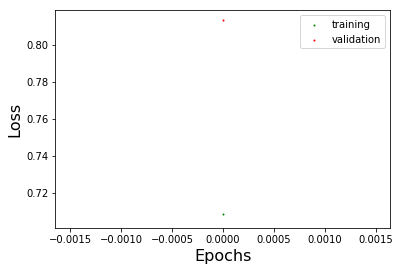

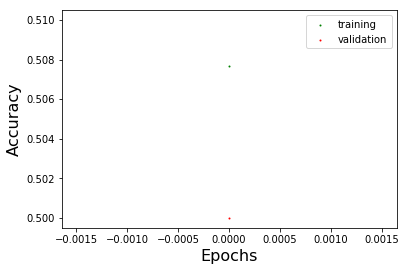

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 1. TrainL 0.640011727809906. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616877555847.
Epoch 2. TrainL 0.6089621186256409. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616877555847. Curr loss 0.8132616281509399.
Epoch 3. TrainL 0.5637260675430298. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 4. TrainL 0.514538049697876. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132615685462952.
Epoch 5. TrainL 0.5000333189964294. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132615685462952. Curr loss 0.8132615685462952.
Epoch 6. TrainL 0.4679575562477112. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1

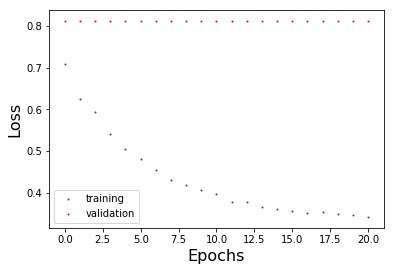

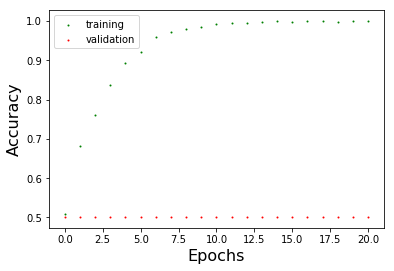

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616877555847. Curr loss 0.8132616281509399.
Epoch 21. TrainL 0.3403090238571167. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 22. TrainL 0.3426949381828308. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616877555847.
Epoch 23. TrainL 0.34136050939559937. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616877555847. Curr loss 0.8132616281509399.
Epoch 24. TrainL 0.33214670419692993. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 25. TrainL 0.3408444821834564. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132615685462952.
Epoch 26. TrainL 0.33172494173049927. ValL 0.8132615685462952. Acc 0.5.
[1 1 1 

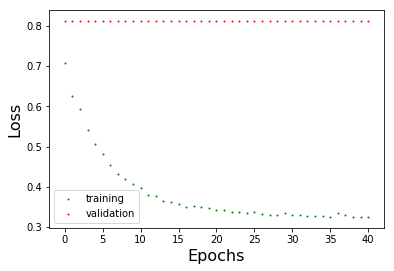

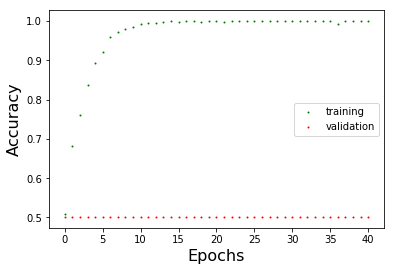

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616877555847.
Epoch 41. TrainL 0.3223665654659271. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616877555847. Curr loss 0.8132616281509399.
Epoch 42. TrainL 0.3203033208847046. ValL 0.813258707523346. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 43. TrainL 0.3219473361968994. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132615685462952.
Epoch 44. TrainL 0.32152265310287476. ValL 0.8132601976394653. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132615685462952. Curr loss 0.8132615089416504.
Epoch 45. TrainL 0.320503830909729. ValL 0.8132607340812683. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132615089416504. Curr loss 0.8132615685462952.
Epoch 46. TrainL 0.32356059551239014. ValL 0.8132615685462952. Acc 0.5.
[1 1 1 1 1

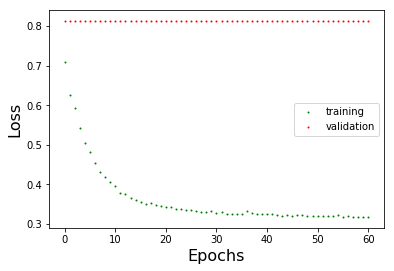

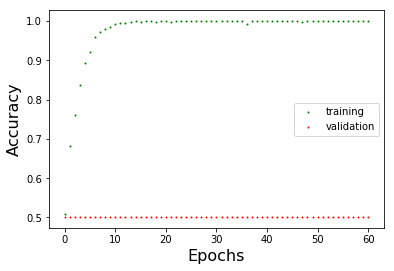

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132615089416504. Curr loss 0.8132615089416504.
Epoch 61. TrainL 0.3173385262489319. ValL 0.8132613301277161. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132615089416504. Curr loss 0.8132615685462952.
Epoch 62. TrainL 0.31821221113204956. ValL 0.8132614493370056. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132615685462952. Curr loss 0.8132604956626892.
Epoch 63. TrainL 0.31754299998283386. ValL 0.8132149577140808. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132604956626892. Curr loss 0.8132604956626892.
Epoch 64. TrainL 0.33044230937957764. ValL 0.813261091709137. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132604956626892. Curr loss 0.8132604956626892.
Epoch 65. TrainL 0.3187294006347656. ValL 0.8132579922676086. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132604956626892. Curr loss 0.8132604956626892.
Epoch 66. TrainL 0.3177465796470642. ValL 0.8132615685462952. Acc 0.5.
[1 1 1 1

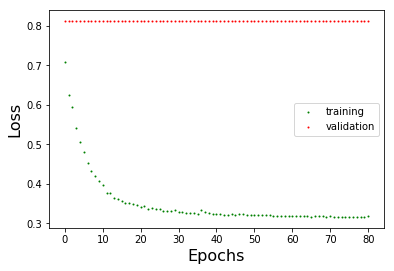

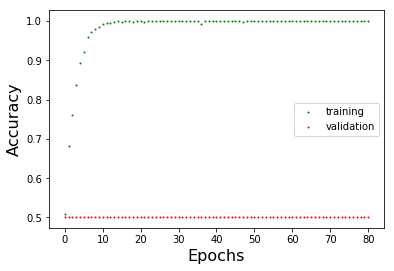

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132598400115967. Curr loss 0.8132597208023071.
Epoch 81. TrainL 0.3157415986061096. ValL 0.8132596611976624. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132597208023071. Curr loss 0.813259482383728.
Epoch 82. TrainL 0.3156963586807251. ValL 0.8132529854774475. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.813259482383728. Curr loss 0.8132593631744385.
Epoch 83. TrainL 0.3162705600261688. ValL 0.8132520318031311. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132593631744385. Curr loss 0.8132591843605042.
Epoch 84. TrainL 0.31686729192733765. ValL 0.8132564425468445. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132591843605042. Curr loss 0.8132572770118713.
Epoch 85. TrainL 0.3161012828350067. ValL 0.8131632208824158. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132572770118713. Curr loss 0.8132566809654236.
Epoch 86. TrainL 0.3152184784412384. ValL 0.813234269618988. Acc 0.5.
[1 1 1 1 1 1

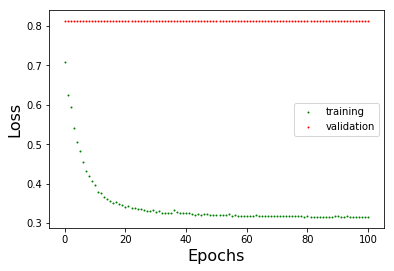

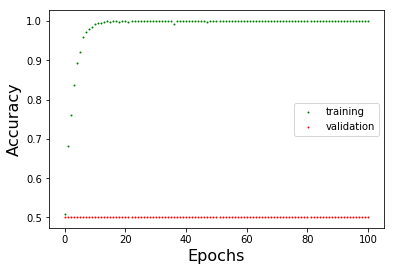

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.813254714012146. Curr loss 0.8132547736167908.
Epoch 101. TrainL 0.31498008966445923. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132547736167908. Curr loss 0.813254714012146.
Epoch 102. TrainL 0.3148097097873688. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.813254714012146. Curr loss 0.813254714012146.
Epoch 103. TrainL 0.3147537112236023. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.813254714012146. Curr loss 0.8132547736167908.
Epoch 104. TrainL 0.31460896134376526. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132547736167908. Curr loss 0.8132547736167908.
Epoch 105. TrainL 0.31609639525413513. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132547736167908. Curr loss 0.8132547736167908.
Epoch 106. TrainL 0.31593984365463257. ValL 0.8132616281509399. Acc 0.5.
[1 1 

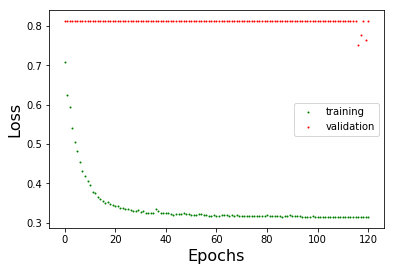

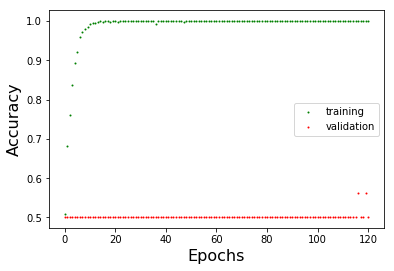

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8102911114692688. Curr loss 0.8102901577949524.
Epoch 121. TrainL 0.3147032856941223. ValL 0.8132115006446838. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8102901577949524. Curr loss 0.8102779388427734.
Epoch 122. TrainL 0.3146539628505707. ValL 0.8126317858695984. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8102779388427734. Curr loss 0.8102684020996094.
Epoch 123. TrainL 0.3143121898174286. ValL 0.8127842545509338. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8102684020996094. Curr loss 0.8102651834487915.
Epoch 124. TrainL 0.3155635595321655. ValL 0.8130984902381897. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8102651834487915. Curr loss 0.8102651834487915.
Epoch 125. TrainL 0.3187258243560791. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8102651834487915. Curr loss 0.8102651834487915.
Epoch 126. TrainL 0.31748685240745544. ValL 0.8132616281509399. Acc 0.5.
[1 

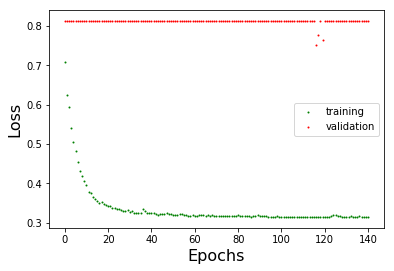

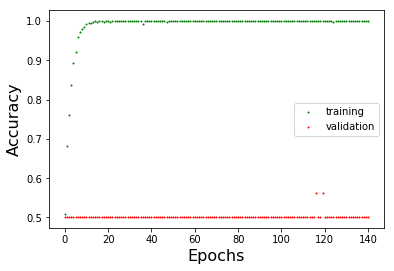

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.810270369052887. Curr loss 0.8102704882621765.
Epoch 141. TrainL 0.3141501843929291. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8102704882621765. Curr loss 0.810270369052887.
Epoch 142. TrainL 0.3146558403968811. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.810270369052887. Curr loss 0.810270369052887.
Epoch 143. TrainL 0.31588345766067505. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.810270369052887. Curr loss 0.810270369052887.
Epoch 144. TrainL 0.3143191337585449. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.810270369052887. Curr loss 0.810270369052887.
Epoch 145. TrainL 0.3141959011554718. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.810270369052887. Curr loss 0.810270369052887.
Epoch 146. TrainL 0.31559184193611145. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1

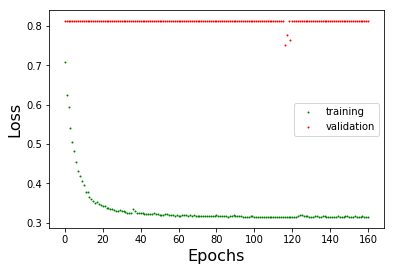

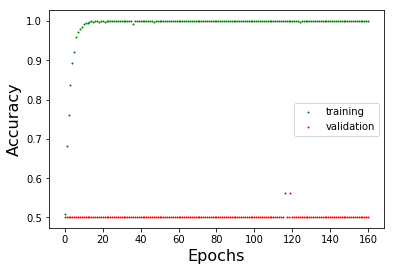

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.810270369052887. Curr loss 0.810270369052887.
Epoch 161. TrainL 0.31406688690185547. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.810270369052887. Curr loss 0.810270369052887.
Epoch 162. TrainL 0.3139059841632843. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.810270369052887. Curr loss 0.810270369052887.
Epoch 163. TrainL 0.3142170310020447. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.810270369052887. Curr loss 0.810270369052887.
Epoch 164. TrainL 0.31461939215660095. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.810270369052887. Curr loss 0.810270369052887.
Epoch 165. TrainL 0.31381702423095703. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.810270369052887. Curr loss 0.8103076219558716.
Epoch 166. TrainL 0.3156808614730835. ValL 0.7536094784736633. Acc 0.5625.
[1 1 1 1 

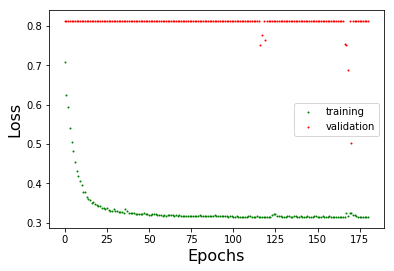

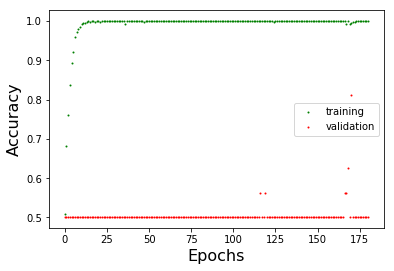

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8020646572113037. Curr loss 0.8020646572113037.
Epoch 181. TrainL 0.3149828314781189. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8020646572113037. Curr loss 0.8020646572113037.
Epoch 182. TrainL 0.315189391374588. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8020646572113037. Curr loss 0.8020646572113037.
Epoch 183. TrainL 0.3146931529045105. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8020646572113037. Curr loss 0.8020646572113037.
Epoch 184. TrainL 0.3147687315940857. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8020646572113037. Curr loss 0.8020646572113037.
Epoch 185. TrainL 0.31434839963912964. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8020646572113037. Curr loss 0.8020646572113037.
Epoch 186. TrainL 0.31392207741737366. ValL 0.8132616281509399. Acc 0.5.
[1 

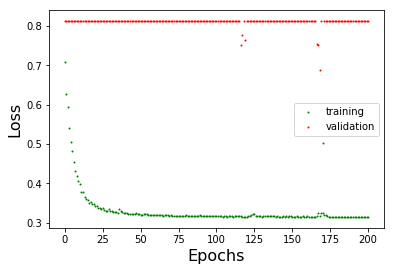

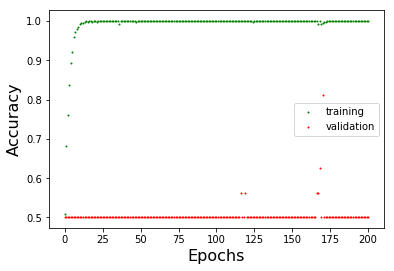

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8020646572113037. Curr loss 0.8020646572113037.
Epoch 201. TrainL 0.3137528896331787. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8020646572113037. Curr loss 0.8020646572113037.
Epoch 202. TrainL 0.31380414962768555. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8020646572113037. Curr loss 0.8020646572113037.
Epoch 203. TrainL 0.3146924376487732. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8020646572113037. Curr loss 0.8020646572113037.
Epoch 204. TrainL 0.31400758028030396. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8020646572113037. Curr loss 0.8020646572113037.
Epoch 205. TrainL 0.31370529532432556. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8020646572113037. Curr loss 0.8020646572113037.
Epoch 206. TrainL 0.3138258457183838. ValL 0.8132616281509399. Acc 0.5.
[

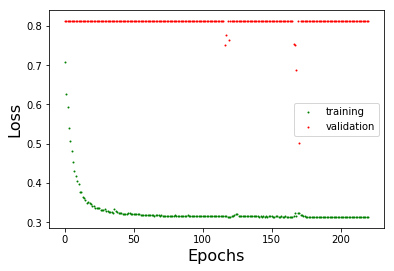

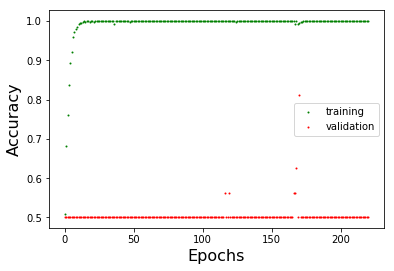

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132615685462952. Curr loss 0.8132616281509399.
Epoch 221. TrainL 0.314879834651947. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 222. TrainL 0.31358933448791504. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 223. TrainL 0.31380343437194824. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 224. TrainL 0.31410032510757446. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 225. TrainL 0.31359314918518066. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 226. TrainL 0.31397855281829834. ValL 0.8132616281509399. Acc 0.5.


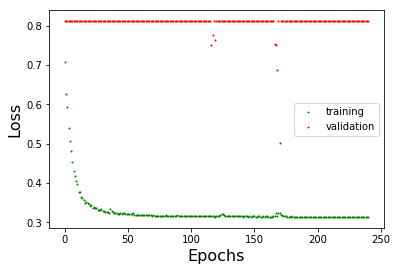

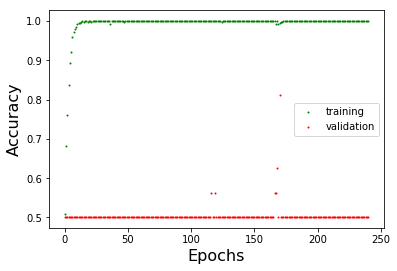

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 241. TrainL 0.313560426235199. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 242. TrainL 0.3134850859642029. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 243. TrainL 0.3135037422180176. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 244. TrainL 0.3140220642089844. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 245. TrainL 0.3135569095611572. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 246. TrainL 0.31360772252082825. ValL 0.8132616281509399. Acc 0.5.
[1 1

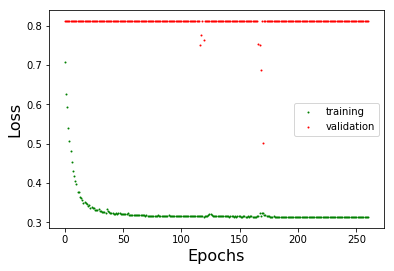

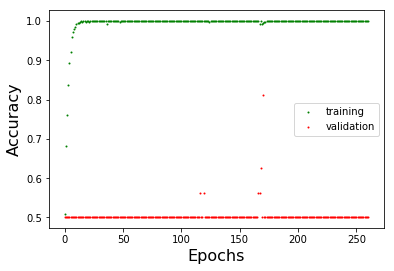

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 261. TrainL 0.31362274289131165. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 262. TrainL 0.31344902515411377. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 263. TrainL 0.3134526014328003. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 264. TrainL 0.31353408098220825. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 265. TrainL 0.31353986263275146. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 266. TrainL 0.3134289085865021. ValL 0.8132616281509399. Acc 0.5.


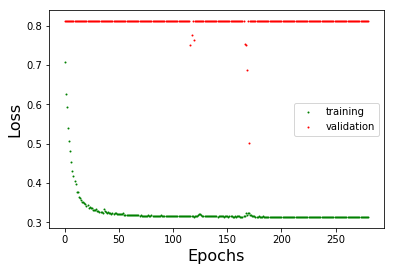

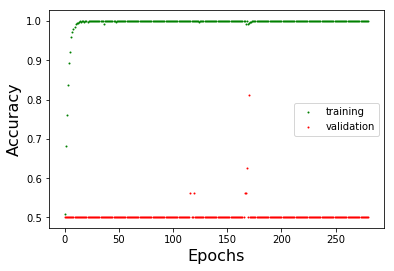

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 281. TrainL 0.3134930729866028. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 282. TrainL 0.31349217891693115. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 283. TrainL 0.3134387135505676. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 284. TrainL 0.31346750259399414. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 285. TrainL 0.3136400580406189. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 286. TrainL 0.3134310245513916. ValL 0.8132616281509399. Acc 0.5.
[1

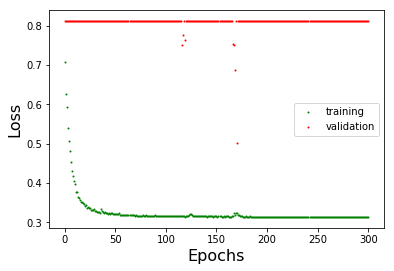

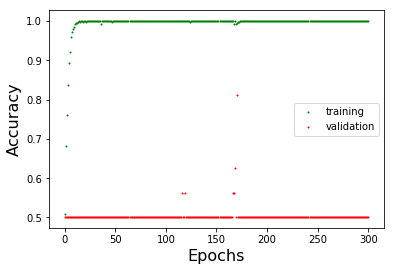

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 301. TrainL 0.3134213387966156. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 302. TrainL 0.3135884404182434. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 303. TrainL 0.3137754201889038. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 304. TrainL 0.313502699136734. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 305. TrainL 0.3134445548057556. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 306. TrainL 0.3143681287765503. ValL 0.8132616281509399. Acc 0.5.
[1 1 

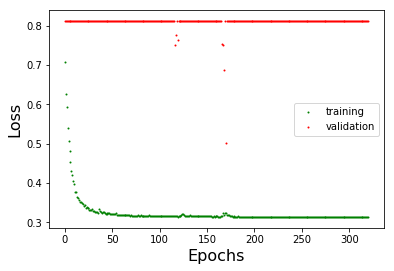

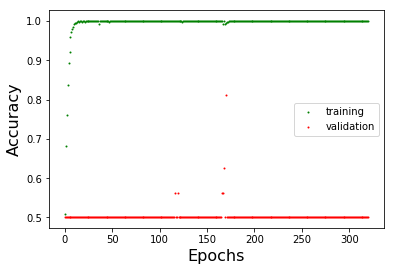

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 321. TrainL 0.31345465779304504. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 322. TrainL 0.3137432336807251. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 323. TrainL 0.3134458661079407. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 324. TrainL 0.31338366866111755. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 325. TrainL 0.31338822841644287. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 326. TrainL 0.31336382031440735. ValL 0.8132616281509399. Acc 0.5.


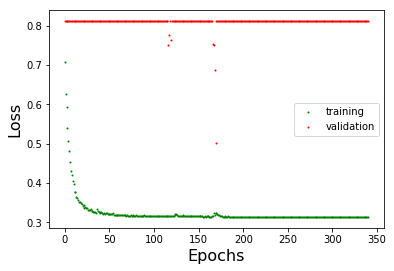

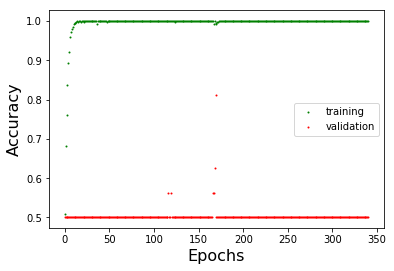

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 341. TrainL 0.3133644461631775. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 342. TrainL 0.3134565055370331. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 343. TrainL 0.3135002851486206. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 344. TrainL 0.31362849473953247. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 345. TrainL 0.3134983777999878. ValL 0.8132615685462952. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 346. TrainL 0.3204701244831085. ValL 0.8132616281509399. Acc 0.5.
[1 

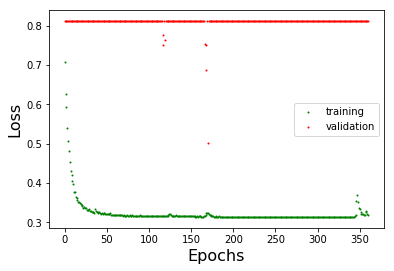

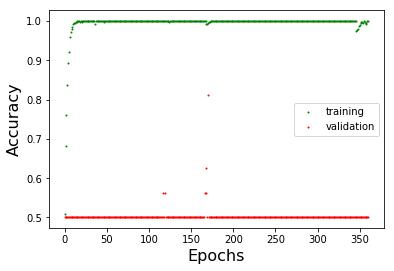

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 361. TrainL 0.3182336688041687. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 362. TrainL 0.3165127635002136. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 363. TrainL 0.31426793336868286. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 364. TrainL 0.31409022212028503. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 365. TrainL 0.3138728141784668. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 366. TrainL 0.3150470554828644. ValL 0.8132616281509399. Acc 0.5.
[1

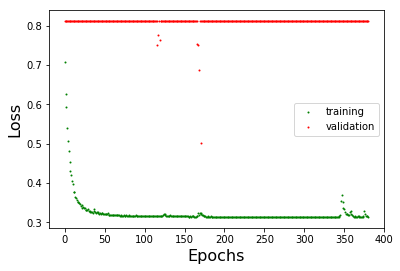

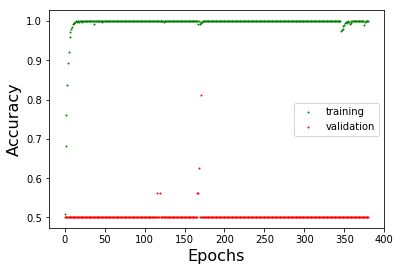

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 381. TrainL 0.3139669597148895. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 382. TrainL 0.31440994143486023. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 383. TrainL 0.3138996660709381. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 384. TrainL 0.3136995732784271. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 385. TrainL 0.31482696533203125. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 386. TrainL 0.31366458535194397. ValL 0.8132616281509399. Acc 0.5.
[

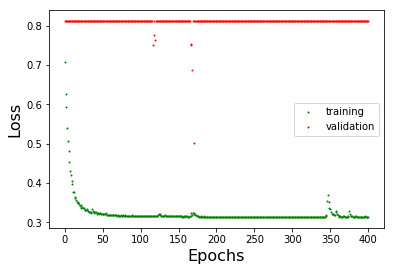

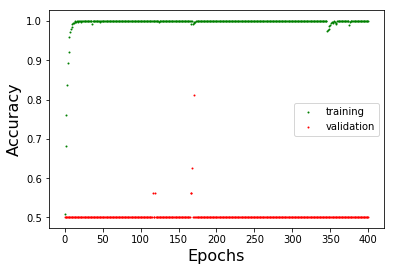

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 401. TrainL 0.3134514093399048. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 402. TrainL 0.31341248750686646. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 403. TrainL 0.31349658966064453. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 404. TrainL 0.3134545087814331. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 405. TrainL 0.31364914774894714. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 406. TrainL 0.3142073452472687. ValL 0.8132616281509399. Acc 0.5.
[

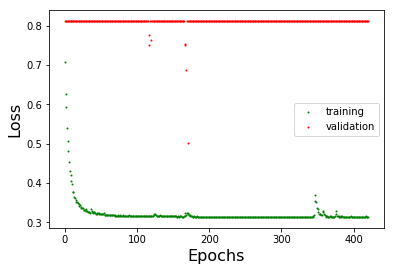

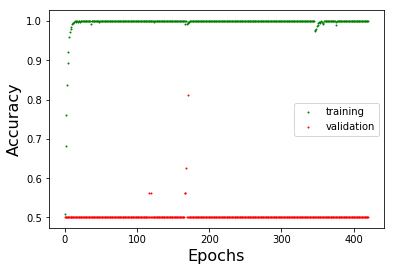

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 421. TrainL 0.3166190981864929. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 422. TrainL 0.31414756178855896. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 423. TrainL 0.313437283039093. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 424. TrainL 0.3134705424308777. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 425. TrainL 0.3135179579257965. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 426. TrainL 0.31337323784828186. ValL 0.8132616281509399. Acc 0.5.
[1 

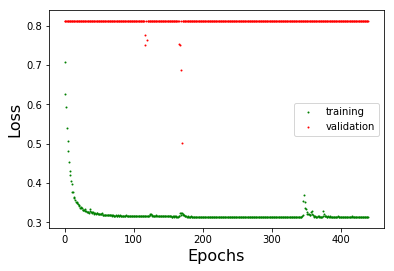

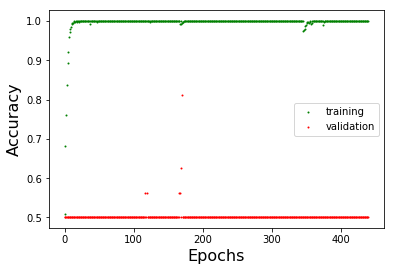

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 441. TrainL 0.3133845627307892. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 442. TrainL 0.3133726418018341. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 443. TrainL 0.31341755390167236. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 444. TrainL 0.31340521574020386. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 445. TrainL 0.3137691617012024. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 446. TrainL 0.31334879994392395. ValL 0.8132616281509399. Acc 0.5.
[

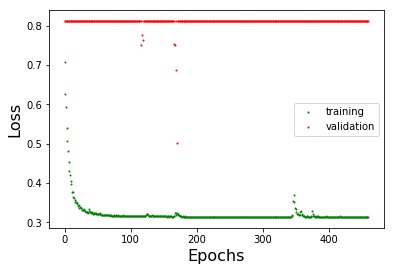

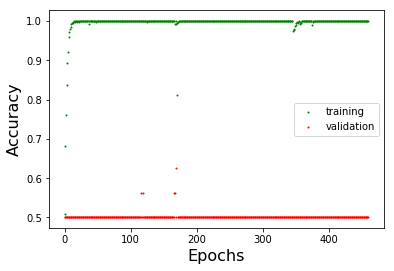

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 461. TrainL 0.313351035118103. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 462. TrainL 0.313454270362854. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 463. TrainL 0.31384342908859253. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 464. TrainL 0.31336820125579834. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 465. TrainL 0.31373733282089233. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 466. TrainL 0.31335970759391785. ValL 0.8132616281509399. Acc 0.5.
[1

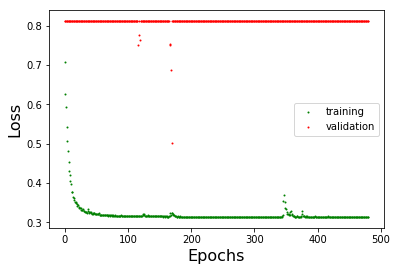

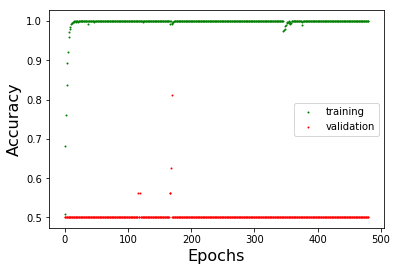

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 481. TrainL 0.31402668356895447. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 482. TrainL 0.3135375678539276. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 483. TrainL 0.3137511610984802. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 484. TrainL 0.31342512369155884. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 485. TrainL 0.3133929371833801. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 486. TrainL 0.3134084939956665. ValL 0.8132616281509399. Acc 0.5.
[1

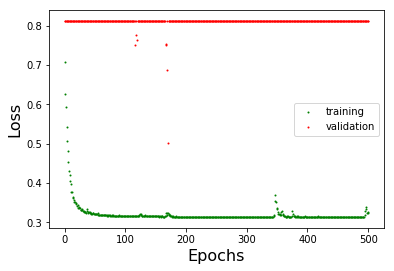

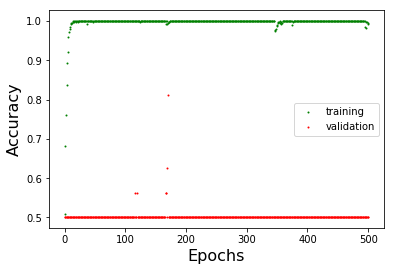

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 501. TrainL 0.31424635648727417. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 502. TrainL 0.3138982653617859. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 503. TrainL 0.31386488676071167. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 504. TrainL 0.313828706741333. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 505. TrainL 0.3138231039047241. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 506. TrainL 0.31377172470092773. ValL 0.8132616281509399. Acc 0.5.
[1

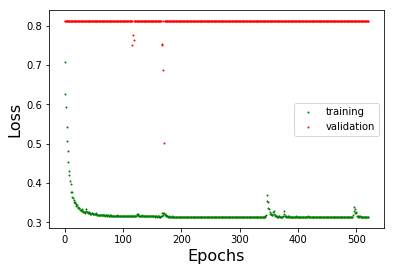

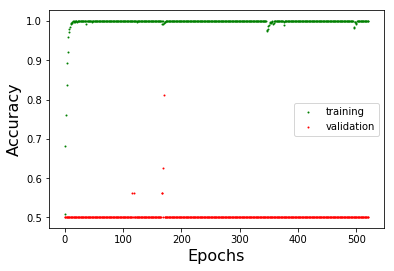

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 521. TrainL 0.3133789598941803. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 522. TrainL 0.31366288661956787. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 523. TrainL 0.3134205639362335. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 524. TrainL 0.31342554092407227. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 525. TrainL 0.31340837478637695. ValL 0.8132616281509399. Acc 0.5.


In [ ]:
saver = tf.train.Saver()

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())

# Params for early stopping
patience = 16
patience_cnt = 0
hist_len = 50
last_avg_loss = 0
hist_loss = []
min_loss_seen = None

batch_size = 32
epoch = 0
while (patience_cnt < patience or epoch < hist_len) and epoch < 1000:
    c = list(zip(tr_data, tr_target))
    random.shuffle(c)
    tr_data, tr_target = zip(*c)

    tr_loss, val_loss, tr_acc, val_acc = (0, 0, 0, 0)
    for j in range(0, len(tr_target), batch_size):

        # Validation conditions
        if j == 0:
            # Get accuracy and loss from validation data
            vLoss, vAcc, vPred = sess.run([loss, accuracy, predicted], 
                                          feed_dict = {x: val_data,
                                                       y_: val_target,
                                                       training: False})
                   
            print(vPred)
            
            # Conditions for early stopping
            if len(hist_loss) == hist_len:
                hist_loss.pop(0)
            hist_loss.append(vLoss)
            curr_loss = np.mean(np.asarray(hist_loss)) 
            
            print("Last loss {}. Curr loss {}.".format(last_avg_loss, curr_loss))
            
            if last_avg_loss > curr_loss:
                patience_cnt = 0
                
                # Save the model 
                if min_loss_seen == None or min_loss_seen > curr_loss:
                    min_loss_seen = curr_loss
                    saver.save(sess, './braincnn-13-model', global_step=epoch)
                    saver.save(sess, './braincnn-13-model-final')
            elif last_avg_loss == curr_loss:
                patience_cnt = 0
            else:
                if epoch >= hist_len:
                    patience_cnt += 1
                
            last_avg_loss = curr_loss
                
        # Training
        rOpt, rLoss, rAcc = sess.run([opt, loss, accuracy], 
                                     feed_dict = {x: tr_data[j:j + batch_size],
                                                  y_: tr_target[j:j + batch_size],
                                                  training: True})

        # Accumulate loss and accuracy stats to later calculate average of epoch
        tr_loss += rLoss
        val_loss += vLoss
        tr_acc += rAcc
        val_acc += vAcc

        if j == 0:
            print('Epoch {}. TrainL {}. ValL {}. Acc {}.'.format(epoch, rLoss, vLoss, vAcc))
    
    num_mini_batches = math.ceil(len(tr_target)/batch_size)
    x_train.append(epoch)
    y_train.append(tr_loss/num_mini_batches)
    x_val.append(epoch)
    y_val.append(val_loss/num_mini_batches)
    x_tr_acc.append(epoch)
    y_tr_acc.append(tr_acc/num_mini_batches)
    x_val_acc.append(epoch)
    y_val_acc.append(val_acc/num_mini_batches)
    
    # Plotting every 20 epochs
    if epoch % 20 == 0:
        plotting((x_train, y_train), (x_val, y_val), (x_tr_acc, y_tr_acc), (x_val_acc, y_val_acc))
    
    # Next epoch
    epoch += 1


In [ ]:
# Plot final graph
plotting((x_train, y_train), (x_val, y_val), (x_tr_acc, y_tr_acc), (x_val_acc, y_val_acc), final=True)


In [ ]:
# Need to restore model saved by early stopping
with tf.Session() as sSess:
    # Restore variables.
    saver.restore(sSess, './braincnn-13-model-final')
    print("Model restored.")
              
    # Get accuracy and loss from validation data
    sPred, sAcc = sSess.run([predicted, accuracy], 
                            feed_dict = {x: test_data,
                                         y_: test_target,
                                         training: False})
    
    print('Predicted classes {}'.format(sPred))
    print('Testing accuracy {}'.format(sAcc))

    # APOE e4 stats for testing data
    e4_carrier_stats_post = {}
    for k in range(0, len(sample_labels)):
        e4_carrier_stats_post[k] = [0, 0]

    # Get testing APOE e4 stats
    for p in range(0, len(sPred)):
        e4_carrier_stats_post[sPred[p]][1] += 1
        if file_to_apoe[apoe_test_files[p]]:
            e4_carrier_stats_post[sPred[p]][0] += 1

    for cl_id, [quant, num_samples] in e4_carrier_stats_post.items():
        if num_samples != 0:
            print("Class {}. Pct APOE e4 carrier {}".format(sample_labels[cl_id], 
                                                            quant/num_samples))